In [1]:
import pandas as pd
from matplotlib import style
style.use('dark_background')

In [2]:
df = pd.read_parquet('datasets/lichess-sampled.parquet')
df.head(3)

,Event,Site,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,TimeControl,Termination,Moves,Date,WhiteTitle,BlackTitle,LichessId
0,Classical,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,White,1654.0,1919.0,19.0,-22.0,D04,480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,2012-12-31 23:04:12,None,None,<NA>
1,Classical,https://lichess.org/iclkx584,Voltvolf,Marzinkus,White,1824.0,1811.0,11.0,-11.0,C02,360+6,Normal,1. e4 e6 2. d4 d5 3. e5 c5 4. c3 Ne7 5. f4 cxd...,2012-12-31 23:10:00,None,None,<NA>
2,Classical,https://lichess.org/ufcqmfxx,6WX,adamsrj,White,1463.0,1504.0,62.0,-12.0,C44,1560+30,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Be7 4. d4 exd4 5. N...,2012-12-31 23:16:04,None,None,<NA>


In [3]:
# Split date into month, year, and day
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head()

,Event,Site,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,TimeControl,Termination,Moves,Date,WhiteTitle,BlackTitle,LichessId,Year,Month,Day
0,Classical,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,White,1654.0,1919.0,19.0,-22.0,D04,480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,2012-12-31 23:04:12,None,None,<NA>,2012,12,31
1,Classical,https://lichess.org/iclkx584,Voltvolf,Marzinkus,White,1824.0,1811.0,11.0,-11.0,C02,360+6,Normal,1. e4 e6 2. d4 d5 3. e5 c5 4. c3 Ne7 5. f4 cxd...,2012-12-31 23:10:00,None,None,<NA>,2012,12,31
2,Classical,https://lichess.org/ufcqmfxx,6WX,adamsrj,White,1463.0,1504.0,62.0,-12.0,C44,1560+30,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Be7 4. d4 exd4 5. N...,2012-12-31 23:16:04,None,None,<NA>,2012,12,31
3,Classical,https://lichess.org/qwuudn2s,sebastian44,jtkjtkful,Black,1347.0,1519.0,-6.0,23.0,B01,300+5,Time forfeit,1. e4 d5 2. e5 d4 3. Nf3 Nc6 4. c3 d3 5. Na3 f...,2012-12-31 23:24:11,None,None,<NA>,2012,12,31
4,Classical,https://lichess.org/c9qfp8es,peter2,Killi,Black,1519.0,1572.0,-9.0,9.0,C28,480+0,Normal,1. e4 Nc6 2. Nc3 e5 3. Bc4 Nf6 4. d3 h6 5. f3 ...,2013-01-01 00:51:20,None,None,<NA>,2013,1,1


In [4]:
white_group = df.groupby('White')
black_group = df.groupby('Black')

In [5]:
# Build a dataframe with data by player
# Find the union of black and white players
players = pd.concat([white_group['White'].agg('count'), black_group['Black'].agg('count')]).index.unique().rename('UserName')

In [6]:
players_df = pd.DataFrame(index=players)
players_df = players_df.merge(white_group['White'].agg('count'), left_index=True, right_index=True, how='outer').fillna(0)
players_df = players_df.merge(black_group['Black'].agg('count'), left_index=True, right_index=True, how='outer').fillna(0)
players_df['TotalGames'] = players_df['White'] + players_df['Black']
players_df

,White,Black,TotalGames
---THEMASTER,0.0,1.0,1.0
---electrify---,1.0,0.0,1.0
--CheckMate--,20.0,30.0,50.0
--INVINCIBLE_,1.0,0.0,1.0
--INVINCIBLE___,0.0,1.0,1.0
...,...,...,...
zzzzzz123456,3.0,7.0,10.0
zzzzzzmnefe,1.0,1.0,2.0
zzzzzzzJoker,1.0,2.0,3.0
zzzzzzzzohhhh,1.0,2.0,3.0


Next I want to figure out which players to drop. For example, from here on out I don't care about 0-game accounts

(0.0, 15.0)

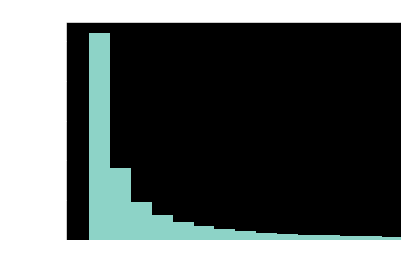

In [7]:
ax1 = players_df['TotalGames'].plot(kind='hist', bins=2000, title='Total Games Played')
ax1.set_xlim(0, 15)

<AxesSubplot:title={'center':'Distribution of accounts by number of games played'}, ylabel='Density'>

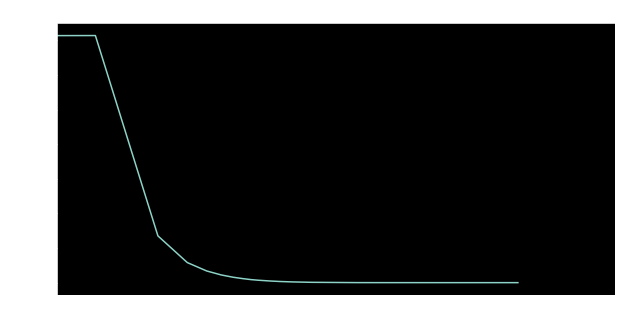

In [8]:
players_df['TotalGames'].plot(kind='density',
                              title='Distribution of accounts by number of games played',
                              logx=True,
                              xlabel='Total Games Played',
                              xlim=(1, 15000),
                              figsize=(10,5))

In [9]:
# What is the proportion of burner accounts, or accounts that have only played one game?
# Actually this data is technically meaningless, since this dataset contains only 1/25 of the total games played.
burner_accounts = players_df[players_df['TotalGames'] == 1]['TotalGames'].count()
inactive_percentage = burner_accounts / players_df['TotalGames'].count()
print(f'{burner_accounts}, or {inactive_percentage *100:.2f}% of players have played just one game.')

522079, or 43.76% of players have played just one game.


In [10]:
white_wins = df[df['Result'] == 'White'].groupby('White')['White'].agg('count').rename('WhiteWins')
black_wins = df[df['Result'] == 'Black'].groupby('Black')['Black'].agg('count').rename('BlackWins')
players_df = players_df.merge(white_wins, left_index=True, right_index=True, how='left').fillna(0)
players_df = players_df.merge(black_wins, left_index=True, right_index=True, how='left').fillna(0)
players_df['TotalWins'] = players_df['WhiteWins'] + players_df['BlackWins']
players_df

,White,Black,TotalGames,WhiteWins,BlackWins,TotalWins
---THEMASTER,0.0,1.0,1.0,0.0,0.0,0.0
---electrify---,1.0,0.0,1.0,0.0,0.0,0.0
--CheckMate--,20.0,30.0,50.0,5.0,15.0,20.0
--INVINCIBLE_,1.0,0.0,1.0,0.0,0.0,0.0
--INVINCIBLE___,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...
zzzzzz123456,3.0,7.0,10.0,2.0,3.0,5.0
zzzzzzmnefe,1.0,1.0,2.0,1.0,0.0,1.0
zzzzzzzJoker,1.0,2.0,3.0,0.0,2.0,2.0
zzzzzzzzohhhh,1.0,2.0,3.0,0.0,1.0,1.0


In [11]:
players_df.sort_values('TotalGames', ascending=False).head(10)

,White,Black,TotalGames,WhiteWins,BlackWins,TotalWins
Snowden,961.0,917.0,1878.0,607.0,561.0,1168.0
v_clava38,733.0,706.0,1439.0,454.0,393.0,847.0
cleoplatre,662.0,662.0,1324.0,374.0,344.0,718.0
capobruno,644.0,639.0,1283.0,307.0,295.0,602.0
2700172,522.0,609.0,1131.0,232.0,249.0,481.0
Ivorybags,495.0,533.0,1028.0,206.0,203.0,409.0
maia1,406.0,615.0,1021.0,207.0,286.0,493.0
jebisesome,490.0,522.0,1012.0,295.0,278.0,573.0
vranishjoti,504.0,503.0,1007.0,255.0,226.0,481.0
sergei48,479.0,480.0,959.0,216.0,207.0,423.0


In [12]:
players_df['WinRatio'] = players_df['TotalWins'] / (players_df['TotalGames'] - players_df['TotalWins'])
players_df.sort_values('WinRatio', ascending=False)

,White,Black,TotalGames,WhiteWins,BlackWins,TotalWins,WinRatio
zzzzzzzzzzzzf,1.0,0.0,1.0,1.0,0.0,1.0,inf
Jordieboi4,1.0,0.0,1.0,1.0,0.0,1.0,inf
Jordy16,0.0,1.0,1.0,0.0,1.0,1.0,inf
Jordrow,0.0,1.0,1.0,0.0,1.0,1.0,inf
Timine,1.0,0.0,1.0,1.0,0.0,1.0,inf
...,...,...,...,...,...,...,...
jballs7,0.0,1.0,1.0,0.0,0.0,0.0,0.0
NazarVolkov,0.0,1.0,1.0,0.0,0.0,0.0,0.0
jbaliga,2.0,0.0,2.0,0.0,0.0,0.0,0.0
Nazar_1,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [13]:
white_elo_gain = df[df['WhiteRatingDiff'] > 0].groupby('White')['WhiteRatingDiff'].agg('sum').rename('WhiteEloGain')
white_elo_loss = -df[df['WhiteRatingDiff'] < 0].groupby('White')['WhiteRatingDiff'].agg('sum').rename('WhiteEloLoss')
black_elo_gain = df[df['BlackRatingDiff'] > 0].groupby('Black')['BlackRatingDiff'].agg('sum').rename('BlackEloGain')
black_elo_loss = -df[df['BlackRatingDiff'] < 0].groupby('Black')['BlackRatingDiff'].agg('sum').rename('BlackEloLoss')
players_df = players_df.merge(white_elo_gain, left_index=True, right_index=True, how='left').fillna(0)
players_df = players_df.merge(white_elo_loss, left_index=True, right_index=True, how='left').fillna(0)
players_df = players_df.merge(black_elo_gain, left_index=True, right_index=True, how='left').fillna(0)
players_df = players_df.merge(black_elo_loss, left_index=True, right_index=True, how='left').fillna(0)
players_df['TotalEloGain'] = players_df['WhiteEloGain'] + players_df['BlackEloGain']
players_df['TotalEloLoss'] = players_df['WhiteEloLoss'] + players_df['BlackEloLoss']
players_df['TotalEloChange'] = players_df['TotalEloGain'] - players_df['TotalEloLoss']
players_df.head()

,White,Black,TotalGames,WhiteWins,BlackWins,TotalWins,WinRatio,WhiteEloGain,WhiteEloLoss,BlackEloGain,BlackEloLoss,TotalEloGain,TotalEloLoss,TotalEloChange
---THEMASTER,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,117.0,0.0,117.0,-117.0
---electrify---,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,138.0,0.0,0.0,0.0,138.0,-138.0
--CheckMate--,20.0,30.0,50.0,5.0,15.0,20.0,0.666667,68.0,116.0,195.0,188.0,263.0,304.0,-41.0
--INVINCIBLE_,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,193.0,0.0,0.0,0.0,193.0,-193.0
--INVINCIBLE___,0.0,1.0,1.0,0.0,1.0,1.0,inf,0.0,0.0,142.0,0.0,142.0,0.0,142.0


<AxesSubplot:title={'center':'Games Played by Year'}, xlabel='Year'>

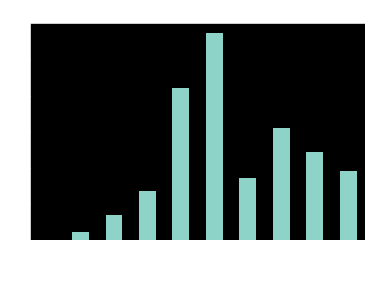

In [14]:
# plot number of games played by year
df.groupby('Year')['Year'].agg('count').plot(kind='bar', title='Games Played by Year')

<AxesSubplot:title={'center':'Games Played by Month in 2017'}, xlabel='Month'>

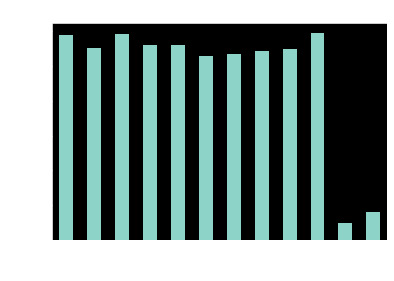

In [14]:
# plot games by month in 2017
df[df['Year'] == 2017].groupby('Month')['Month'].agg('count').plot(kind='bar', title='Games Played by Month in 2017')

In [15]:
df[(df['White'] == 'Snowden') | (df['Black'] == 'Snowden')]

,Event,Site,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,TimeControl,Termination,Moves,WhiteTitle,BlackTitle,LichessId,Date,Year,Month,Day
5787,Classical,https://lichess.org/gOjRQj08,Snowden,Niagua,White,1443.0,1581.0,47.0,-27.0,C55,480+0,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. d4 Nxe4 5. d...,NaN,NaN,<NA>,2014-02-18 03:07:17,2014,2,18
5795,Classical,https://lichess.org/5eAhUZG9,chan2,Snowden,Black,1666.0,1533.0,-15.0,27.0,B00,480+0,Normal,1. e4 Nc6 2. d4 e5 3. d5 Nce7 4. Nc3 Ng6 5. h3...,NaN,NaN,<NA>,2014-02-18 04:30:17,2014,2,18
6118,Classical,https://lichess.org/ioeqdS87,rama2014,Snowden,Black,1513.0,1586.0,-9.0,10.0,A00,480+0,Normal,1. e3 e5 2. Qh5 Nc6 3. Bc4 g6 4. Qf5 gxf5 5. B...,NaN,NaN,<NA>,2014-02-19 03:33:47,2014,2,19
6469,Classical,https://lichess.org/JNaEcE1N,kin_agin,Snowden,White,1818.0,1628.0,6.0,-5.0,B00,480+0,Normal,1. e4 Nc6 2. d4 e5 3. d5 Nce7 4. Nf3 Ng6 5. Bc...,NaN,NaN,<NA>,2014-02-20 04:02:43,2014,2,20
7791,Classical,https://lichess.org/iH6MiDSX,Snowden,revolution21,White,1484.0,1276.0,5.0,-5.0,C41,600+0,Normal,1. e4 e5 2. Nf3 d6 3. d4 Nd7 4. Bc4 Qe7 5. O-O...,NaN,NaN,<NA>,2014-02-23 23:02:42,2014,2,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106717,Classical,https://lichess.org/nHsc5XMX,Snowden,rribak,Black,1756.0,1715.0,-14.0,12.0,C56,480+0,Normal,1. e4 { [%clk 0:08:00] } e5 { [%clk 0:08:00] }...,NaN,NaN,<NA>,2017-10-28 20:05:47,2017,10,28
111621,Classical,https://lichess.org/gbCK2yl8,JoelTibaldo,Snowden,Black,1560.0,1697.0,-8.0,8.0,B00,480+0,Normal,1. e4 { [%clk 0:08:00] } Nc6 { [%clk 0:08:00] ...,NaN,NaN,<NA>,2017-10-30 01:53:38,2017,10,30
115463,Classical,https://lichess.org/D9BLgKy2,SERG0,Snowden,Black,1595.0,1685.0,-12.0,10.0,B00,480+0,Time forfeit,1. e4 { [%clk 0:08:00] } Nc6 { [%clk 0:08:00] ...,NaN,NaN,<NA>,2017-10-31 00:16:54,2017,10,31
118960,Classical,https://lichess.org/VxEb6SbG,cescandon,Snowden,White,1649.0,1722.0,12.0,-16.0,B00,480+0,Normal,1. e4 { [%clk 0:08:00] } Nc6 { [%clk 0:08:00] ...,NaN,NaN,<NA>,2017-10-31 21:36:44,2017,10,31


In [18]:
# Get the current rating of the top 10 players by number of games played
top_players = players_df.sort_values('TotalGames', ascending=False).head(10)
# Get the last game played by each of these players
top_players.index

Index(['Snowden', 'v_clava38', 'cleoplatre', 'capobruno', '2700172',
       'Ivorybags', 'maia1', 'jebisesome', 'vranishjoti', 'sergei48'],
      dtype='object')

In [33]:
top_players_games = df[(df['White'].isin(top_players.index)) | (df['Black'].isin(top_players.index))]

In [26]:
# get the last games played by each of these players
last_games = [top_players_games[(top_players_games['White'] == player) | (top_players_games['Black'] == player)].iloc[-1] for player in top_players.index]

In [20]:
# extract the ELO from each of these games
last_games_elo = {player: game['WhiteElo'] if game['White'] == player else game['BlackElo'] for player, game in zip(top_players.index, last_games)}
last_games_elo

{'Snowden': 1696.0,
 'v_clava38': 1768.0,
 'cleoplatre': 1516.0,
 'capobruno': 1682.0,
 '2700172': 1913.0,
 'Ivorybags': 1849.0,
 'maia1': 1459.0,
 'jebisesome': 1889.0,
 'vranishjoti': 1787.0,
 'sergei48': 1620.0}